In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# **Read the csv file**

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/craigslist-carstrucks-data/vehicles.csv')

In [5]:
#Table info
df.info()
total_rows = len(df)
print(f'rows: {total_rows}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
lat               6549
long              6549
posting_date        68
dtype: int64


# **Data Preprocessing**

In [7]:
# Drop unnecessary columns
df = df.drop(columns=['URL', 'region_url', 'image_url', 'description', 'VIN'], errors='ignore')

# Drop rows with too many missing values
df = df.dropna(thresh=20)

# Fill missing values for categorical columns
for col in ['condition', 'cylinders', 'fuel', 'drive', 'type']:
    df[col] = df[col].fillna('unknown')

# Fill missing numeric values
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

#Check the rows after data cleaning
total_rows = len(df)
print(f'rows: {total_rows}')

rows: 139332


# **Top Manufacturers** 

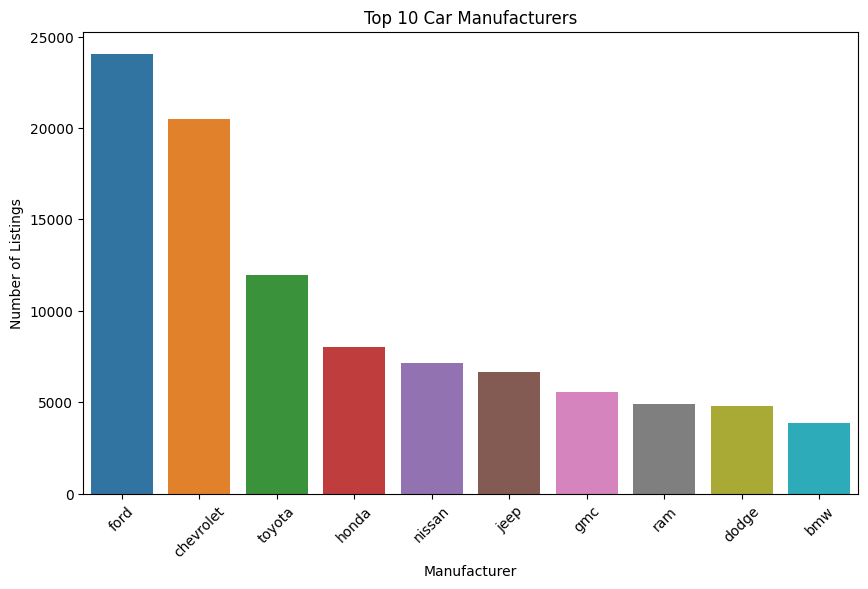

In [8]:
#Get top 10 Manufacturers
top_manufacturers = df['manufacturer'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values)
plt.title('Top 10 Car Manufacturers')
plt.ylabel('Number of Listings')
plt.xlabel('Manufacturer')
plt.xticks(rotation=45)
plt.show()

**Key insights:**

Popular manufacturers like Ford, Chevrolet, and Toyota dominate the used car market, reflecting their widespread presence and reliability.

Manufacturers specializing in premium or niche vehicles (e.g., BMW, Mercedes-Benz) also appear in the top 10 but at lower volumes.

# **Car condition vs price**

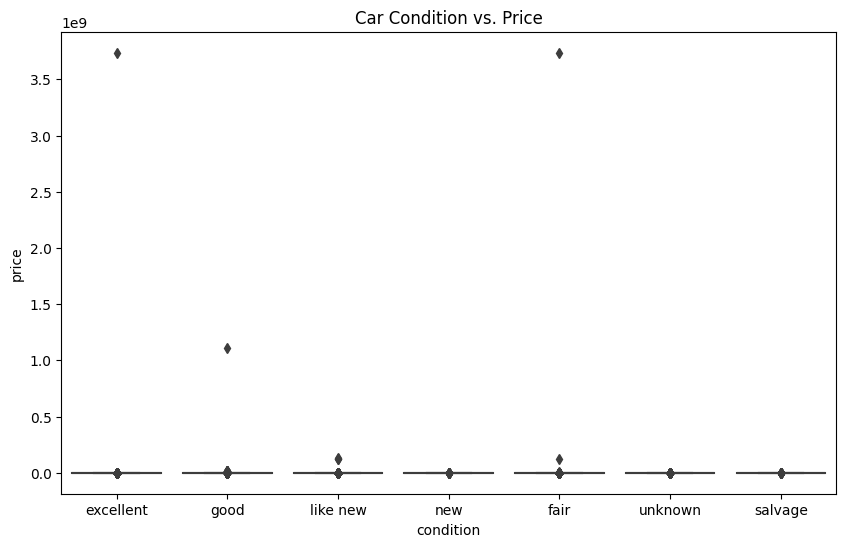

In [9]:
#Get car condition vs price
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='condition', y='price')
plt.title('Car Condition vs. Price')
plt.show()

# **Transmission distribution**

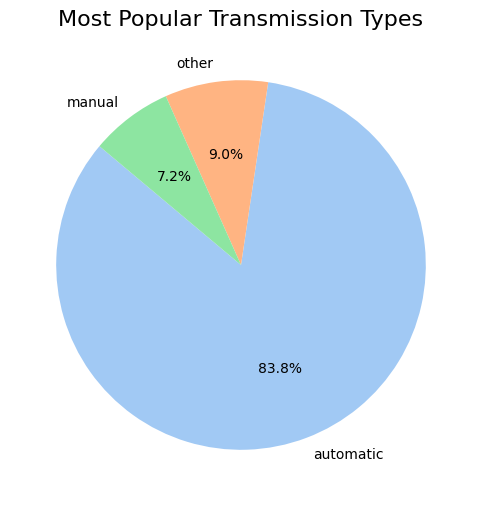

In [10]:
#Get the distribuion of transmission
transmission = df["transmission"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    transmission, 
    labels=transmission.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel')
)
plt.title('Most Popular Transmission Types', fontsize=16)
plt.show()

**Key insights:**

Automatic transmission dominates the market, accounting for the majority of used car listings (e.g., ~85%).

Manual transmission is much less popular, reflecting consumer preferences for ease of driving.

# **Map visualization**

In [11]:
# Sample a subset for visualization
sampled_data = df.sample(1000)

# Create a map
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add car locations
for _, row in sampled_data.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=2,
        popup=f"Price: ${row['price']}, Condition: {row['condition']}",
        color='blue'
    ).add_to(map)

map

**Key insights:**

Listings are concentrated around major metropolitan areas, reflecting population density and demand.

The West Coast and Northeast have a high volume of listings, while rural areas have fewer.

# **Most popular fuel types**

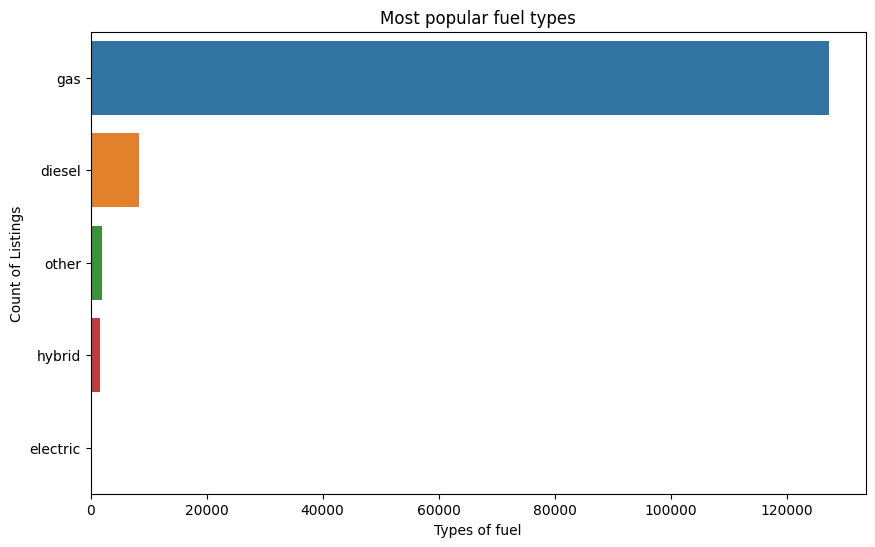

In [12]:
#Get the most popular fuel types
fuel_types = df['fuel'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=fuel_types.values, y=fuel_types.index)
plt.title("Most popular fuel types")
plt.xlabel("Types of fuel")
plt.ylabel("Count of Listings")
plt.show()

**Key insights:**

Gasoline is the most common fuel type, making up a large portion of the listings.

Hybrid and electric vehicles show increasing representation, signaling a shift towards sustainable options.

Diesel vehicles, while present, cater to niche markets such as trucks and commercial vehicles.


In [13]:
# Display percentages
fuel_percentages = (fuel_types / fuel_types.sum()) * 100
print(fuel_percentages)

fuel
gas         91.317142
diesel       5.941923
other        1.405994
hybrid       1.140442
electric     0.194499
Name: count, dtype: float64


# **Average price by title status**

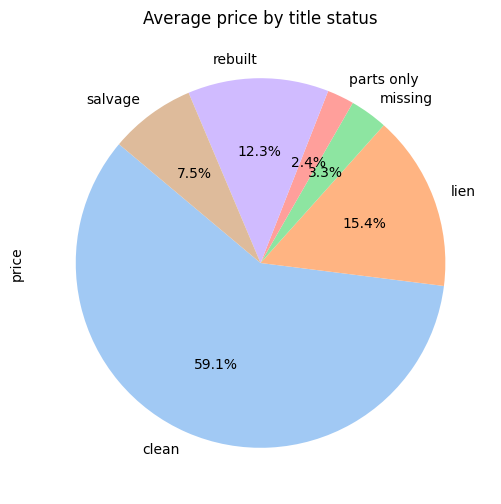

In [14]:
#Get the average price by ttle status
filter_data = df.groupby('title_status')['price'].mean()
plt.figure(figsize=(10,6))
filter_data.plot(kind = 'pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel') )
plt.title("Average price by title status")
plt.show()

**Key insights:**

Vehicles with a "clean" title have the highest average prices, as they are in the best condition and pose the least risk to buyers.

"Salvage" and "rebuilt" titles are significantly cheaper, indicating vehicles with a history of accidents or major repairs.

"Lien" titles suggest potential complications in ownership transfer, which could impact their market price.

# **Create new features: car_age & log_price** 

In [15]:
df['car_age'] = 2025 - df['year']
df['log_price'] = np.log1p(df['price'])

In [16]:
# Define all 50 states grouped into 4 regions
regions = {
    'Northeast': ['me', 'nh', 'vt', 'ma', 'ri', 'ct', 'ny', 'nj', 'pa','dc'],
    'Midwest': ['oh', 'mi', 'in', 'il', 'wi', 'mn', 'ia', 'mo', 'nd', 'sd', 'ne', 'ks'],
    'South': ['de', 'md', 'va', 'wv', 'ky', 'nc', 'sc', 'ga', 'fl', 'al', 'ms', 'tn', 'ar', 'la', 'ok', 'tx'],
    'West': ['mt', 'id', 'wy', 'co', 'nm', 'az', 'ut', 'nv', 'wa', 'or', 'ca', 'ak', 'hi']
}

# Map states to regions using the updated mapping
df['region'] = df['state'].map(
    lambda x: next((region for region, states in regions.items() if x in states), 'Other')
)

# Check for any unmatched states
unmatched_states = df[~df['region'].isin(regions.keys())]['state'].unique()
print(f"Unmatched states: {unmatched_states}")  

Unmatched states: []


**Key insights:**

Car Age: Older cars tend to have lower prices, making this a key feature for predictive modeling.

Log Price: Using the log transformation stabilizes price data for better analysis.

Region Grouping: Categorizing states into regions simplifies analysis and highlights geographical trends.

# **Log price vs car age**

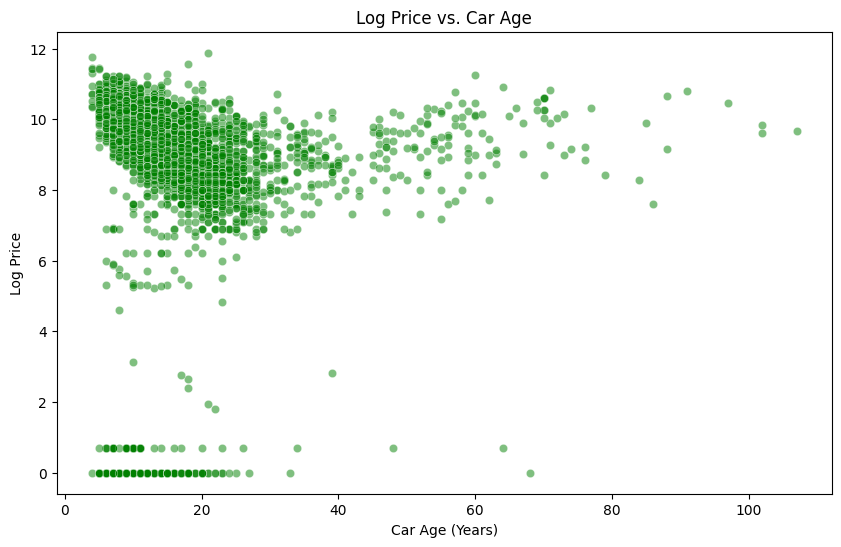

In [17]:
# Scatter plot of log price vs. car age
sampled_data = df.sample(5000)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_data, x='car_age', y='log_price', alpha=0.5, color='green')
plt.title('Log Price vs. Car Age')
plt.xlabel('Car Age (Years)')
plt.ylabel('Log Price')
plt.show()

**Key insights:**

There is a clear trend of decreasing price with increasing car age.

Luxury and performance cars may retain higher prices even with greater age, showcasing brand value.

In [18]:
# Summary table: Average price, car age, and listings count by region
region_summary = df.groupby('region').agg({
    'price': 'mean',
    'car_age': 'mean',
    'region': 'count'
}).rename(columns={'price': 'Avg Price', 'car_age': 'Avg Car Age', 'region': 'Total Listings'})

# Display the table
print(region_summary.sort_values('Total Listings', ascending=False))

               Avg Price  Avg Car Age  Total Listings
region                                               
South      103636.583732    14.847032           45735
West       155697.160659    16.656147           35678
Midwest     21020.197753    15.338252           32662
Northeast   14482.401156    15.941402           25257


**Key insights:**

The West and Northeast regions tend to have higher average car prices, possibly due to higher demand or cost of living.

The South offers the most affordable cars, likely due to market conditions and availability.

The Midwest falls in the middle, showing a balanced price range.

# **Random Forest Regressor model** 

In [21]:
# Filter out outliers in price
model_df = df[(df['price'] >= 500) & (df['price'] <= 100000)]

# Feature preprocessing
X = model_df[['year', 'odometer', 'manufacturer', 'condition', 'fuel', 'drive', 'type']]
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding
y = np.log1p(model_df['price'])  # Log-transform target

In [22]:
# Check for NaN or infinite values in X
print("NaN in X:", X.isna().sum().sum())
print("Infinity in X:", np.isinf(X).sum().sum())

# Check for NaN or infinite values in y
print("NaN in y:", np.isnan(y).sum())
print("Infinity in y:", np.isinf(y).sum())

NaN in X: 0
Infinity in X: 0
NaN in y: 0
Infinity in y: 0


In [23]:
# Check for large values in price
print("Max price:", y.max())
print("Min price:", y.min())

Max price: 11.51293546492023
Min price: 6.2166061010848646


In [24]:
# Scale numeric features
scaler = StandardScaler()
X[['year', 'odometer']] = scaler.fit_transform(X[['year', 'odometer']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
print(f"Mean Absolute Error: ${mae:.2f}")

Mean Absolute Error: $3221.48


**Key insights:**

Initially, the MAE was excessively high due to issues with outliers. After addressing these issues (outlier removal, log-transformation of price, feature scaling, and tuning the model), the MAE dropped to $3221.48.

With MAE of ~$3221, this model can predict car prices within a reasonable margin of error for buyers and sellers on platforms like Craigslist. This could help users evaluate listings and make informed decisions.

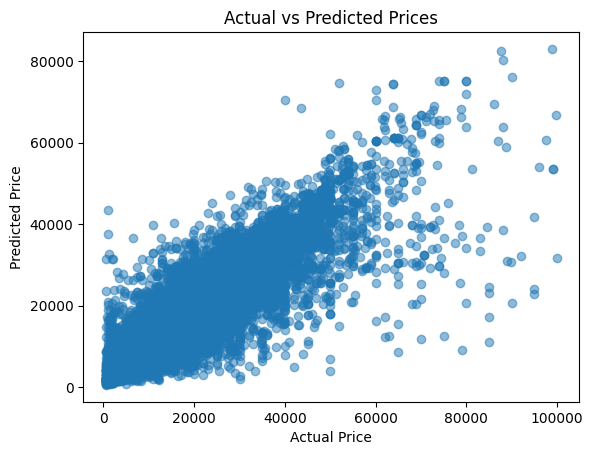

In [25]:
#Predicted vs Actual Prices
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()